<a href="https://colab.research.google.com/github/hunterwyork/text_analysis/blob/master/old_bailey_bertopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Old Bailey Archive - PunishmentSummaries

At the end of each session in the 1700s, all of the punishments from the proceeding trials of the day are read aloud. These form separate instances in the old bailey archives and are rather easy to pull out (as opposed to trying to parse within each trial what the punishment is). 

However, since they are read aloud all at once, it is difficult to connect them to their corresponding offenses. While this certainly can be done, I'm just going to do a simple analysis to begin with on all the punishments at once.

Below is a simple graph showing the distribution of punishments by type of crime for this time period. I'll extend to 1900 once the data is done extracting, but sadly my scraping code is a little slow.
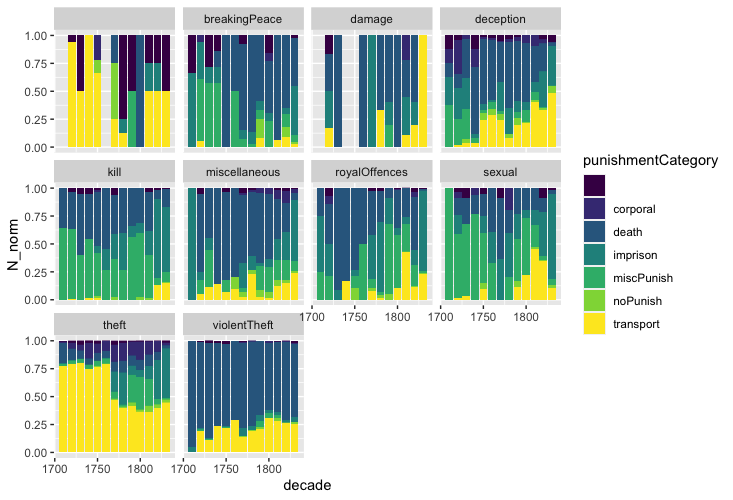


In [106]:
%%capture
#!pip install bertopic


In [107]:
import pandas as pd
#trials_df = pd.read_csv("/content/drive/MyDrive/first_500_trials_pun.csv")
#trials_df2 = pd.read_csv("/content/drive/MyDrive/second_500_trials_pun.csv")
trials_df = pd.read_csv("/content/drive/MyDrive/first_1000_appended.csv")
#trials_df.append(trials_df2,ignore_index=True)
#trials_df2

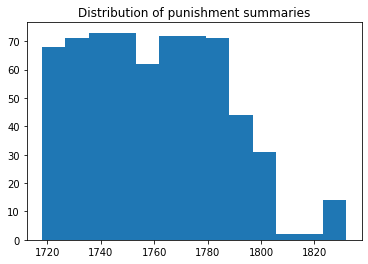

In [136]:
temp = trials_df[trials_df['type'] == "punishmentSummary"]
import numpy as np
a = [int(str(x)[0:4]) for x in temp['date']]
import matplotlib.pyplot as plt

_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram

plt.title("Distribution of punishment summaries")

plt.show()

KeyError: ignored

In [109]:
temp = trials_df[trials_df['type'] == "punishmentSummary"]
temp = temp.reset_index(drop=True)

paragraphs = temp['text'].values.tolist()


## Regularizing Early Modern English

I found a package that regularizes irregular spellings. See github for info.

In [110]:
!pip install git+https://github.com/jrladd/regularize.git

  Cloning https://github.com/jrladd/regularize.git to /tmp/pip-req-build-d4inn1d6
  Running command git clone -q https://github.com/jrladd/regularize.git /tmp/pip-req-build-d4inn1d6
  Created wheel for regularize: filename=regularize-0.5-cp37-none-any.whl size=3491848 sha256=846e2336bfaef6033f09a51df3994e378bcddf06de50a8f0e5ed9fbde8a3780b
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6edoz0s/wheels/cf/6b/bb/dd7d90a2012b5c9c5d5135673a958fc23b12c47536103e7341
Successfully built regularize


In [111]:
from regularize import regularize as reg
paragraphs = [reg.modernize(item) for item in paragraphs]

paragraphs[0:9]

["The Trials being over the Court proceeded to give Judgement as follows: Received Sentence of Death,5. Edward Williams , Benjamin Tyser , Marry Price , George Chambers , Elizabeth Cave . Burned in the Hand,2. James Quinn and Thomas Abnett To be Transported,19. Thomas Harris , Katherine Roffe , Marry Wade , John Mills William Ward , William Wellington , Thomas Free , Benjamim Brand , Bridget Noland , Susan Chapman , Sarah Morgan , Marry Wilson , John Long , John Master's , Thomas Booth , Philip Goodson , Ann Thomas , James Dillon , Marry Wright . Dorothy Crier , to be Whipped. Roberst Harrison, Fined 20 Marks,6 Months Imprisonment, and to stand in the Pillory. John Collet , Fined 20 S.",
 'The Trials being over, the Court proceeded to give Judgement as Follows: Received Sentence or death,13 James Brown , John Wood , James Violet alias Filewood. Francis Flood ; John Brown , Charles Campbell , Samuel Coal , Joseph Dod, Henry May , John Hill , Henry Abbot , William Greenwood , Robert Foot

Some punishment summaries are rather long. It is an option to split them up by sentences. 

In [112]:
# Load the regular expression library
import re# Remove punctuation
paragraphs_clean = [x.lower() for x in paragraphs]
paragraphs_clean = [re.sub('[0-9]', '', x) for x in paragraphs_clean]# Convert the titles to lowercase

# !pip install embedded_topic_model
def convert(lst):
    return (lst.split("."))

sentences = [convert(lst) for lst in paragraphs_clean]

flat_sentences = [item for sublist in sentences for item in sublist]



flat_sentences = [re.sub('[,\.!?]', '', x) for x in flat_sentences]# Convert the titles to lowercase


In [113]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["the", "trial","trials","being","ended", "court", "proceeded","to",
                   "give", "judgement", "as", "follows", "follow", "received", "sentence", "of"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Try Bert-contextualized embeddings

This method doesn't like proper names and numbers. First step is to replace those with the tokens "person" and "cardinal."

In [114]:
import spacy
nlp = spacy.load('en_core_web_sm')
nlps = [nlp(x) for x in flat_sentences]





In [115]:

def no_namer(doc):
  text_no_namedentities = ""
  for chunk in doc:
      if (chunk.ent_type_ != "PERSON") & (chunk.ent_type_ != "CARDINAL"):
          text_no_namedentities += chunk.text
          if chunk.whitespace_:
                  text_no_namedentities += " "
      elif chunk.ent_type_ == "PERSON":
          text_no_namedentities += "person"
          if chunk.whitespace_:
                  text_no_namedentities += " "
      elif chunk.ent_type_ == "CARDINAL":
          text_no_namedentities += "cardinal"
          if chunk.whitespace_:
                  text_no_namedentities += " "
  return text_no_namedentities
print([no_namer(x) for x in nlps[1:5]])
print(flat_sentences[1:5])

flat_sentences_arch = flat_sentences.copy
flat_sentences = [no_namer(x) for x in nlps]
flat_sentences[1:10]

[' person person  person person  marry price  person person  person cave ', ' burned in the hand', ' person person and person person to be transported', ' person person  person person  person person  person person person person  person person  person free  benjamim brand  bridget noland  person person  person person  person person  person person  person personperson  person booth  person person  person person  person person  person person ']
[' edward williams  benjamin tyser  marry price  george chambers  elizabeth cave ', ' burned in the hand', ' james quinn and thomas abnett to be transported', " thomas harris  katherine roffe  marry wade  john mills william ward  william wellington  thomas free  benjamim brand  bridget noland  susan chapman  sarah morgan  marry wilson  john long  john master's  thomas booth  philip goodson  ann thomas  james dillon  marry wright "]


[' person person  person person  marry price  person person  person cave ',
 ' burned in the hand',
 ' person person and person person to be transported',
 ' person person  person person  person person  person person person person  person person  person free  benjamim brand  bridget noland  person person  person person  person person  person person  person personperson  person booth  person person  person person  person person  person person ',
 ' dorothy crier  to be whipped',
 ' roberst harrison fined  marks months imprisonment and to stand in the pillory',
 ' person person  fined  s',
 '',
 'the trials being over the court proceeded to give judgement as follows: received sentence or death person person  person person  person person alias filewood']

In [116]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1,1), stop_words=stop_words)
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics=90)
topics, _ = topic_model.fit_transform(flat_sentences)

In [117]:
topic_model.get_topics()

{-1: [('personperson', 0.004078921128814477),
  ('stealing', 0.004004226158574067),
  ('case', 0.003574401459218875),
  ('convicted', 0.003315160568338466),
  ('read', 0.0033049731151263825),
  ('eleanor', 0.003135318917886225),
  ('prisoners', 0.003046957281266633),
  ('law', 0.0028405608432412405),
  ('stolen', 0.002789910242727096),
  ('former', 0.002692488359791367)],
 0: [('col', 0.741424217468737),
  ('agar', 0.23156586640451393),
  ('colman', 0.19494545678224362),
  ('rawlins', 0.17184055076357876),
  ('messrs', 0.17184055076357876),
  ('clear', 0.1583250471599733),
  ('job', 0.14359728875067201),
  ('evans', 0.11120193598303979),
  ('faucett', 0.0),
  ('fayler', 0.0)],
 1: [('ann', 0.004101118663409265),
  ('lice', 0.0031562816865676594),
  ('crees', 0.0031562816865676594),
  ('jarborne', 0.0031562816865676594),
  ('creese', 0.0031562816865676594),
  ('grue', 0.0031562816865676594),
  ('currants', 0.0031562816865676594),
  ('ingersol', 0.0031562816865676594),
  ('rhymes', 0.003

In [118]:
fig = topic_model.visualize_topics(); fig

In [119]:
timestamps = [temp['date'][n] for n in range(len(sentences)) for k in range(len(sentences[n]))]


In [120]:
tops_by_time = topic_model.topics_over_time(docs=flat_sentences, 
                                                topics=topics, 
                                                timestamps = timestamps, 
                                                nr_bins = 5,
                                                global_tuning=True,
                                            evolution_tuning = True,
                                            datetime_format = "%Y%m%d")



In [121]:
topics = np.unique(np.reshape(np.array([topic_model.find_topics(x)[0] for x in ["prison", "whip","whipping", "imprison", "jailed", 
                                                                                "sentence","hanged", "death","hang", "jail",
                                                                                "execute", "executed"]]), newshape = -1))
topics = topics.tolist()
topic_model.visualize_topics_over_time(tops_by_time, topics = topics)

In [126]:
trials_df[['date','occupations', 'offenceCategory', "offenceSubcategory", 'verdictCategory', 'punishmentText', 'punishmentCategory', 'punishmentSubcategory']].to_csv("/content/drive/MyDrive/first_1000_appended_slim.csv")